## Clustering

## K-Means application: create 'personas'.

The objective of this project is to segment users according to their online transactions in order to create marketing personas and personalize future marketing campaigns.

Libraries:

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import pickle
import yaml

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

YAML file parameters:

In [48]:
try: 
    with open ("./../params.yaml", 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')

### 1. Load and transform data

For this clustering project we are going to use a sample Instacart dataset and the unsupervised learning algorithm K-Means. This sample includes the online transactions of about 50,000 users over a period of one year. 

In [3]:
instacart = pd.read_csv(config['data']['instacart_sample'])
print('Shape:', instacart.shape)
print('Transactions:', instacart['order_id'].nunique())
print('Users:', instacart['user_id'].nunique())
instacart.drop('Unnamed: 0', axis=1, inplace=True)
instacart.head()

Shape: (5204393, 15)
Transactions: 761900
Users: 49949


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,department_id,aisle_id,aisle,department
0,6,22352,4,1,12,30.0,15873,2,0,Dryer Sheets Geranium Scent,17,75.0,laundry,household
1,8,3107,5,4,6,17.0,23423,1,1,Original Hawaiian Sweet Rolls,3,43.0,buns rolls,bakery
2,13,45082,2,6,17,1.0,3800,12,0,Hampshire 100% Natural Sour Cream,16,108.0,other creams cheeses,dairy eggs
3,13,45082,2,6,17,1.0,25783,7,0,Lemon Lime Thirst Quencher,7,64.0,energy sports drinks,beverages
4,13,45082,2,6,17,1.0,23020,10,0,Diet Tonic Water,7,77.0,soft drinks,beverages


#### 1.1 Select and transform features for K Means algorithm

As mentioned above, the main goal of this project is to create 'marketing personas' in order to redirect Instacart's marketing strategy. Therefore, we need to classify each user according to their transactions.

In order to reduce the number of features presents in the dataset, I have applied PCA to the department columns (aisles did not give such great results, neither did features as 'days_since_prior_order' or number of orders by users).

The next steps to perform are:

1. Select data
2. Apply OneHotEncoder
3. Scale the data with MinMaxScaler
4. Apply PCA

In [4]:
instacart_beta = instacart.copy()
instacart_beta.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,add_to_cart_order,product_name,aisle,department
0,6,22352,4,1,12,2,Dryer Sheets Geranium Scent,laundry,household
1,8,3107,5,4,6,1,Original Hawaiian Sweet Rolls,buns rolls,bakery
2,13,45082,2,6,17,12,Hampshire 100% Natural Sour Cream,other creams cheeses,dairy eggs
3,13,45082,2,6,17,7,Lemon Lime Thirst Quencher,energy sports drinks,beverages
4,13,45082,2,6,17,10,Diet Tonic Water,soft drinks,beverages


In [5]:
instacart_dpt = instacart_beta[['department']]
instacart_dpt.head()

We apply OneHotEncoder on the categorical data and then add up each purchase made on each department by user.

In [6]:
ohe = OneHotEncoder(handle_unknown='ignore').fit(instacart_dpt)

filename = config['encoders']['ohe']
with open(filename, "wb") as file:
        pickle.dump(ohe,file)

X = ohe.transform(instacart_dpt).toarray()
X_df = pd.DataFrame(X, columns = ohe.get_feature_names_out())
X_df

,department_alcohol,department_babies,department_bakery,department_beverages,department_breakfast,department_bulk,department_canned goods,department_dairy eggs,department_deli,department_dry goods pasta,...,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5204389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5204390,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5204391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
X_df['user_id'] = instacart_beta['user_id']
X_df = X_df.groupby('user_id').sum()

Scale data with MinMaxScaler and test PCA parameters (variance level we want to include). 

In [10]:
scaler = MinMaxScaler()
scaler.fit(X_df)

filename = config['scalers']['mimax']
with open(filename, "wb") as file:
        pickle.dump(scaler,file)
        
X_scaled = scaler.transform(X_df)
X_scaled = pd.DataFrame(X_scaled, columns = X_df.columns)

In [42]:
pca = PCA(.95)
pca.fit(X_scaled)
print('Components for departments:', pca.n_components_)

pca = PCA(.80)
pca.fit(X_scaled)
print('Components for departments:', pca.n_components_)

pca = PCA(.70)
pca.fit(X_scaled)
print('Components for departments:', pca.n_components_)

pca = PCA(.65)
pca.fit(X_scaled)

print('Components for departments:', pca.n_components_)
      
pca = PCA(.55)
pca.fit(X_scaled)

print('Components for departments:', pca.n_components_)
      
pca = PCA(.50)
pca.fit(X_scaled)

print('Components for departments:', pca.n_components_)    

Components for departments: 17
Components for departments: 9
Components for departments: 6
Components for departments: 5
Components for departments: 3
Components for departments: 2


In [46]:
pca = PCA(n_components=2)
pca.fit(X_scaled)
pca_samples_x = pca.transform(X_scaled)
ps_x = pd.DataFrame(pca_samples_x, columns = ['PC1', 'PC2'])
ps_x.head()

,PC1,PC2
0,-0.064383,0.008739
1,-0.002090,0.021635
2,-0.041382,-0.009405
3,-0.077639,0.001675
4,-0.054559,-0.016715


Training a K-Means model with 2 neighbours.
Training a K-Means model with 3 neighbours.
Training a K-Means model with 4 neighbours.
Training a K-Means model with 5 neighbours.
Training a K-Means model with 6 neighbours.
Training a K-Means model with 7 neighbours.


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

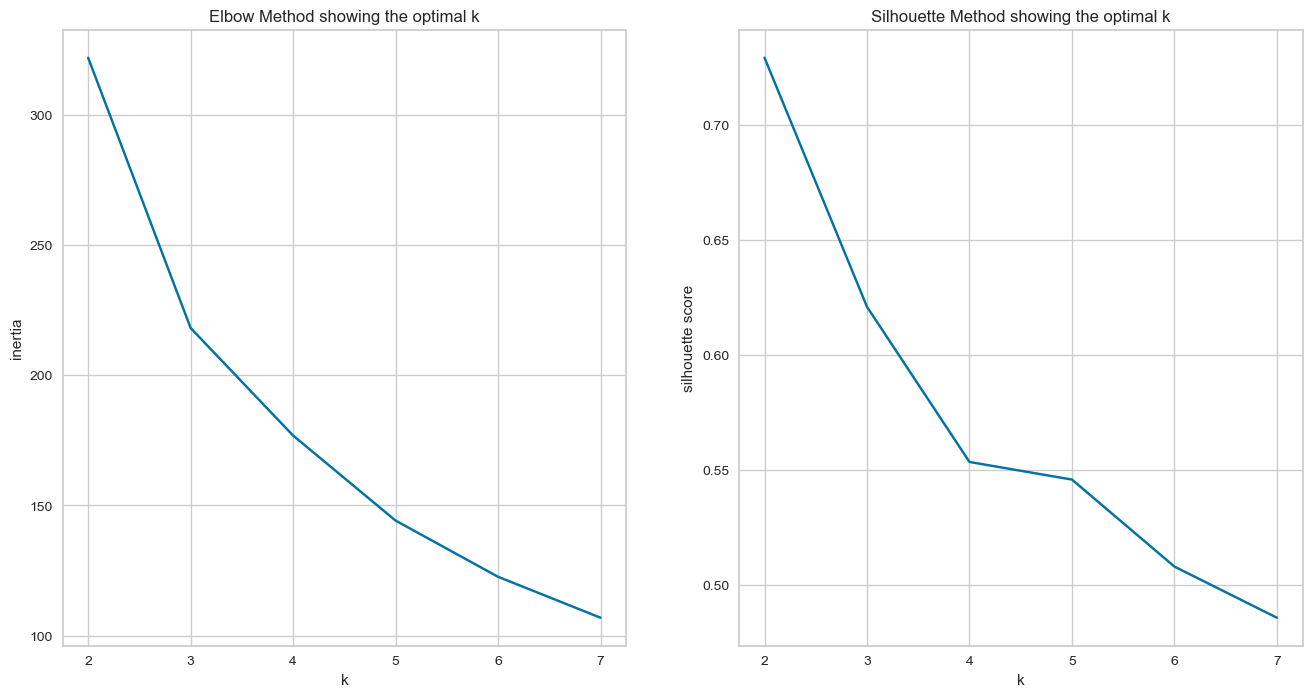

In [44]:
K = range(2, 8)
inertia = []
silhouette = []
for k in K:
    print("Training a K-Means model with {} neighbours.".format(k))
    kmeans = KMeans(n_clusters = k,
                    random_state = config['models']['kmeans_randomstate'])
    kmeans.fit(ps_x)
    filename = config['models']['kmeans_path'] + str(k) + ".pickle"
    with open(filename, "wb") as file:
        pickle.dump(kmeans,file)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(ps_x, kmeans.predict(ps_x)))

# Plot the results
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

In [99]:
last_chance = X_scaled[['department_produce', 'department_dairy eggs',
                       'department_frozen', 'department_snacks']]
last_chance.head()

,department_produce,department_dairy eggs,department_frozen,department_snacks
0,0.006547,0.009868,0.000000,0.040385
1,0.026187,0.038377,0.045643,0.075000
2,0.032733,0.009868,0.016598,0.017308
3,0.001637,0.000000,0.004149,0.001923
4,0.026187,0.005482,0.008299,0.001923


In [ ]:
K = range(2, 8)
inertia = []
silhouette = []
for k in K:
    print("Training a K-Means model with {} neighbours.".format(k))
    kmeans = KMeans(n_clusters = k,
                    random_state = config['models']['kmeans_randomstate'])
    kmeans.fit(last_chance)
#     filename = config['models']['kmeans_path'] + str(k) + ".pickle"
#     with open(filename, "wb") as file:
#         pickle.dump(kmeans,file)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(last_chance, kmeans.predict(last_chance)))

# Plot the results
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

Training a K-Means model with 2 neighbours.
Training a K-Means model with 3 neighbours.
Training a K-Means model with 4 neighbours.
Training a K-Means model with 5 neighbours.


In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))
axs = 2 
for i in [4,5,6,7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state=1234)
          
    q, mode = divmod(axs, 2)
    
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mode])
    visualizer.fit(last_chance)
    axs+=1

# It looks like there's a turning point at 3 clusters (low inertia, high silhoutte score). Nevertheless, we would like to have more granularity in our data, so let's pick k=4.

In [58]:
with open(config['models']['kmeans_path_k'], 'rb') as f:
    km3 = pickle.load(f)
    
km3

KMeans(n_clusters=3, random_state=1234)

In [59]:
y_means3 = km3.labels_
y_means3

array([0, 0, 0, ..., 1, 2, 0])

In [60]:
with open('../models/kmeans_scaled_4.pickle', 'rb') as f:
    km4 = pickle.load(f)

y_means4 = km4.labels_
y_means4

array([0, 2, 0, ..., 2, 1, 0])

In [ ]:
with open('../models/kmeans_scaled_5.pickle', 'rb') as f:
    km4 = pickle.load(f)

y_means5 = km5.labels_
y_means5

In [61]:
user_id = instacart_beta['user_id'].unique()
id_label = pd.DataFrame(user_id, columns = ['user_id'])
id_label['cluster_3'] = y_means3
id_label['cluster_4'] = y_means4
id_label.head()

,user_id,cluster_3,cluster_4
0,22352,0,0
1,3107,0,2
2,45082,0,0
3,18194,0,0
4,30822,0,0


In [62]:
instacart_beta = instacart_beta.merge(id_label, how='left', on='user_id')
instacart_beta.head(20)

,order_id,user_id,order_number,order_dow,order_hour_of_day,add_to_cart_order,product_name,aisle,department,cluster,cluster_3,cluster_4
0,6,22352,4,1,12,2,Dryer Sheets Geranium Scent,laundry,household,0,0,0
1,8,3107,5,4,6,1,Original Hawaiian Sweet Rolls,buns rolls,bakery,0,0,2
2,13,45082,2,6,17,12,Hampshire 100% Natural Sour Cream,other creams cheeses,dairy eggs,0,0,0
3,13,45082,2,6,17,7,Lemon Lime Thirst Quencher,energy sports drinks,beverages,0,0,0
4,13,45082,2,6,17,10,Diet Tonic Water,soft drinks,beverages,0,0,0
5,13,45082,2,6,17,2,Chunky Salsa Medium,preserved dips spreads,pantry,0,0,0
6,13,45082,2,6,17,1,Light,beers coolers,alcohol,0,0,0
7,13,45082,2,6,17,4,Soda,soft drinks,beverages,0,0,0
8,13,45082,2,6,17,13,Original Potato Chips,chips pretzels,snacks,0,0,0
9,13,45082,2,6,17,6,G Series Lime Cucumber Sports Drink,energy sports drinks,beverages,0,0,0


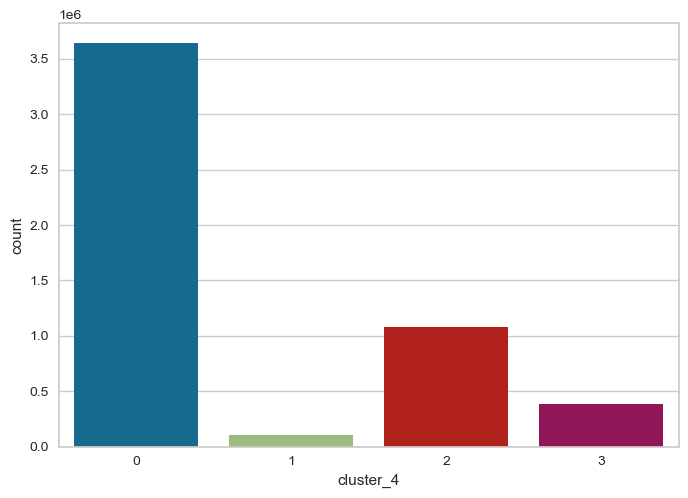

In [64]:
sns.countplot(instacart_beta['cluster_4'])
plt.show()

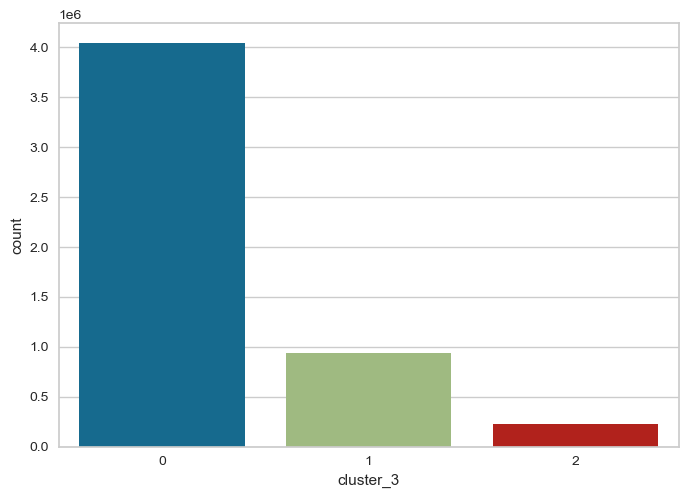

In [65]:
sns.countplot(instacart_beta['cluster_3'])
plt.show()

In [66]:
instacart_beta.to_csv(config['data']['instacart_labels'])

In [69]:
# clusters = pd.read_csv(config['data']['instacart_labels'])
clusters.drop('Unnamed: 0', axis=1, inplace=True)
clusters.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,add_to_cart_order,product_name,aisle,department,cluster,cluster_3,cluster_4
0,6,22352,4,1,12,2,Dryer Sheets Geranium Scent,laundry,household,0,0,0
1,8,3107,5,4,6,1,Original Hawaiian Sweet Rolls,buns rolls,bakery,0,0,2
2,13,45082,2,6,17,12,Hampshire 100% Natural Sour Cream,other creams cheeses,dairy eggs,0,0,0
3,13,45082,2,6,17,7,Lemon Lime Thirst Quencher,energy sports drinks,beverages,0,0,0
4,13,45082,2,6,17,10,Diet Tonic Water,soft drinks,beverages,0,0,0


In [98]:
y = clusters.groupby(['user_id', 'order_id', 'order_number']).max()
y

order_dow  order_hour_of_day  \
user_id order_id order_number                                 
1       431534   5                     4                 15   
        473747   3                     3                 12   
        550135   7                     1                  9   
        2254736  4                     4                  7   
        2295261  9                     1                 16   
...                                  ...                ...   
50000   307244   6                     1                 15   
        494799   3                     5                 17   
        1748471  5                     0                 20   
        2483202  4                     1                 15   
        3163710  7                     0                 13   

                               add_to_cart_order  \
user_id order_id order_number                      
1       431534   5                             8   
        473747   3                             5   
        550135   7                             5   
        2254736  4                             5   
        2295261  9                             6   
...                                          ...   
50000   307244   6                            11   
        494799   3                            15   
        1748471  5                            13   
        2483202  4                            21   
        3163710  7                            17   

                                                          product_name  \
user_id order_id order_number                                            
1       431534   5                                                Soda   
        473747   3                                                Soda   
        550135   7                                                Soda   
        2254736  4                    XL Pick-A-Size Paper Towel Rolls   
        2295261  9                                                Soda   
...                                                                ...   
50000   307244   6                                 Sea Salt Pita Chips   
        494799   3             Sprouted Wheat Onion & Poppyseed Bagels   
        1748471  5                        Sustainably Soft Bath Tissue   
        2483202  4                                   Shredded Parmesan   
        3163710  7                              Unsweetened Almondmilk   

                                     aisle department  cluster  cluster_3  \
user_id order_id order_number                                               
1       431534   5             soft drinks     snacks        0          0   
        473747   3                 spreads     snacks        0          0   
        550135   7             soft drinks     snacks        0          0   
        2254736  4             soft drinks     snacks        0          0   
        2295261  9             soft drinks     snacks        0          0   
...                                    ...        ...      ...        ...   
50000   307244   6                  yogurt     snacks        0          0   
        494799   3                 spreads    produce        0          0   
        1748471  5             paper goods    produce        0          0   
        2483202  4                  yogurt    produce        0          0   
        3163710  7                  yogurt    produce        0          0   

                               cluster_4  
user_id order_id order_number             
1       431534   5                     0  
        473747   3                     0  
        550135   7                     0  
        2254736  4                     0  
        2295261  9                     0  
...                                  ...  
50000   307244   6                     0  
        494799   3                     0  
        1748471  5                     0  
        2483202  4                     0  
        3163710  7                     0  

[761900 r

In [88]:
t = clusters[clusters['cluster_4'] == 0]
t['aisle'].value_counts().head(30)

fresh fruits                     411210
fresh vegetables                 364467
packaged vegetables fruits       190159
yogurt                           152134
milk                             118383
packaged cheese                  116228
water seltzer sparkling water     88467
chips pretzels                    80005
bread                             73328
soy lactosefree                   66874
frozen produce                    66800
refrigerated                      64621
eggs                              55899
ice cream ice                     53536
crackers                          50544
energy granola bars               48133
lunch meat                        46318
fresh dips tapenades              44580
cereal                            43807
soft drinks                       43051
soup broth bouillon               42614
canned jarred vegetables          39857
fresh herbs                       39142
baby food formula                 39008
frozen meals                      38767


In [89]:
s = clusters[clusters['cluster_4'] == 1]
s['aisle'].value_counts().head(30)

fresh fruits                     12975
fresh vegetables                 11048
packaged vegetables fruits        5328
yogurt                            4510
milk                              3714
packaged cheese                   3127
chips pretzels                    2334
water seltzer sparkling water     2307
bread                             2110
frozen produce                    2052
refrigerated                      1881
soy lactosefree                   1730
ice cream ice                     1701
baby food formula                 1700
eggs                              1540
crackers                          1531
lunch meat                        1517
energy granola bars               1428
soup broth bouillon               1340
fresh dips tapenades              1268
soft drinks                       1255
fresh herbs                       1202
cereal                            1126
packaged produce                  1069
canned jarred vegetables          1062
frozen meals             

In [92]:
y = clusters[clusters['cluster_4'] == 2]
y['aisle'].value_counts(normalize=True).head(30)

fresh fruits                     0.114227
fresh vegetables                 0.101189
packaged vegetables fruits       0.052461
yogurt                           0.042814
milk                             0.031975
packaged cheese                  0.031618
water seltzer sparkling water    0.024049
chips pretzels                   0.021716
bread                            0.020181
soy lactosefree                  0.018019
frozen produce                   0.017942
refrigerated                     0.017061
eggs                             0.015047
ice cream ice                    0.014969
crackers                         0.014507
energy granola bars              0.013969
lunch meat                       0.013403
cereal                           0.012584
fresh dips tapenades             0.012525
soup broth bouillon              0.011363
soft drinks                      0.011213
canned jarred vegetables         0.011059
fresh herbs                      0.010919
baby food formula                0

In [93]:
a = clusters[clusters['cluster_4'] == 3]
a['aisle'].value_counts().head(30)

fresh fruits                     43173
fresh vegetables                 39654
packaged vegetables fruits       19856
yogurt                           16454
milk                             12331
packaged cheese                  11964
water seltzer sparkling water     9169
chips pretzels                    8486
bread                             8004
soy lactosefree                   6981
refrigerated                      6899
frozen produce                    6793
eggs                              6029
energy granola bars               5677
crackers                          5436
ice cream ice                     5411
lunch meat                        5020
cereal                            4515
fresh dips tapenades              4510
soup broth bouillon               4320
baby food formula                 4268
canned jarred vegetables          4165
fresh herbs                       4080
soft drinks                       4001
frozen meals                      3812
baking ingredients       